In [ ]:
%env CUDA_VISIBLE_DEVICES=-1
import numpy as np
import tensorflow as tf
import yfinance as yf
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=-1


In [ ]:
import math
from scipy.stats import norm


def bs_call_price(S, K, T, t, r, sigma):
  """Return Black-Scholes call price at (S, t) where t is current time and T is maturity.
  We assume 0 <= t <= T. If using time-to-maturity tau = T - t, picture will be easier.
  """
  tau = max(T - t, 0.0)
  if tau == 0:
      return np.maximum(S - K, 0.0)
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau) + 1e-12)
  d2 = d1 - sigma * np.sqrt(tau)
  return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

In [ ]:
ticker = "AAPL"
asset = yf.Ticker(ticker)


# Current underlying price
S0_live = asset.history(period="1d")["Close"].iloc[-1]


# Risk-free rate from 13-week T-bill
rate_live = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100.0


# Option chain for implied volatility and ATM strike
expirations = asset.options
chain = asset.option_chain(expirations[0])
calls = chain.calls
atm = calls.iloc[(calls['strike'] - S0_live).abs().argmin()]


K = float(atm['strike'])
r = float(rate_live)
sigma = float(atm['impliedVolatility'])


# Time to maturity in years
exp_date = np.datetime64(expirations[0])
today = np.datetime64(datetime.today().date())
T = float((exp_date - today) / np.timedelta64(365, "D"))
T = max(T, 1e-4)


# Domain for S
S_min = 0.5 * S0_live
S_max = 1.5 * S0_live

In [ ]:
N_f = 20000 # PDE interior points
N_ic = 2000 # terminal condition
N_bc = 2000 # boundary points


# Interior points
S_f = np.random.uniform(S_min, S_max, (N_f,1))
t_f = np.random.uniform(0.0, T, (N_f,1))


# Terminal condition: t = T
S_ic = np.random.uniform(S_min, S_max, (N_ic,1))
t_ic = T * np.ones_like(S_ic)
V_ic = np.maximum(S_ic - K, 0.0)


# Boundary at S=0
S_b1 = np.zeros((N_bc//2,1))
t_b1 = np.random.uniform(0.0, T, (N_bc//2,1))
V_b1 = np.zeros_like(S_b1)


# Boundary at S=S_max
S_b2 = S_max * np.ones((N_bc - N_bc//2,1))
t_b2 = np.random.uniform(0.0, T, (N_bc - N_bc//2,1))
V_b2 = S_b2 - K * np.exp(-r * (T - t_b2))


# Stack boundaries
S_bc = np.vstack([S_b1, S_b2])
t_bc = np.vstack([t_b1, t_b2])
V_bc = np.vstack([V_b1, V_b2])


# --- Split into training/validation sets ---
S_f_train, S_f_val, t_f_train, t_f_val = train_test_split(S_f, t_f, test_size=0.2, random_state=42)
S_ic_train, S_ic_val, t_ic_train, t_ic_val, V_ic_train, V_ic_val = train_test_split(S_ic, t_ic, V_ic, test_size=0.2, random_state=42)
S_bc_train, S_bc_val, t_bc_train, t_bc_val, V_bc_train, V_bc_val = train_test_split(S_bc, t_bc, V_bc, test_size=0.2, random_state=42)


In [ ]:
def normalize(S, t):
  return np.hstack([S / K, t / T])


inputs_f_train = normalize(S_f_train, t_f_train).astype(np.float32)
inputs_f_val = normalize(S_f_val, t_f_val).astype(np.float32)
inputs_ic_train = normalize(S_ic_train, t_ic_train).astype(np.float32)
inputs_ic_val = normalize(S_ic_val, t_ic_val).astype(np.float32)
inputs_bc_train = normalize(S_bc_train, t_bc_train).astype(np.float32)
inputs_bc_val = normalize(S_bc_val, t_bc_val).astype(np.float32)


V_ic_train = V_ic_train.astype(np.float32)
V_ic_val = V_ic_val.astype(np.float32)
V_bc_train = V_bc_train.astype(np.float32)
V_bc_val = V_bc_val.astype(np.float32)

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(2,)),
tf.keras.layers.Dense(64, activation='tanh'),
tf.keras.layers.Dense(64, activation='tanh'),
tf.keras.layers.Dense(64, activation='tanh'),
tf.keras.layers.Dense(1, activation='softplus') # positive output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
def pde_residual(model, S, t, sigma, r):
    S = tf.convert_to_tensor(S)
    t = tf.convert_to_tensor(t)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([S, t])
        inputs = tf.concat([S, t], axis=1)
        V = model(inputs)
        V_S, V_t = tape.gradient(V, [S, t])

    # Compute second derivative outside tape context
    V_SS = tape.gradient(V_S, S)
    del tape  # free memory

    f = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V
    return f

In [ ]:
w_pde = 1.0
w_ic = 10.0
w_bc = 10.0


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)


@tf.function
def train_step():
  with tf.GradientTape() as tape:
    f = pde_residual(model, tf.convert_to_tensor(inputs_f_train[:,0:1]), tf.convert_to_tensor(inputs_f_train[:,1:2]), sigma, r)
    loss_f = tf.reduce_mean(tf.square(f))
    V_ic_pred = model(tf.convert_to_tensor(inputs_ic_train))
    loss_ic = tf.reduce_mean(tf.square(V_ic_train - V_ic_pred))
    V_bc_pred = model(tf.convert_to_tensor(inputs_bc_train))
    loss_bc = tf.reduce_mean(tf.square(V_bc_train - V_bc_pred))
    loss = w_pde*loss_f + w_ic*loss_ic + w_bc*loss_bc
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [ ]:
epochs = 4000
for epoch in range(epochs):
  loss = train_step()
  if epoch % 100 == 0:
    print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

NameError: name 'train_step' is not defined

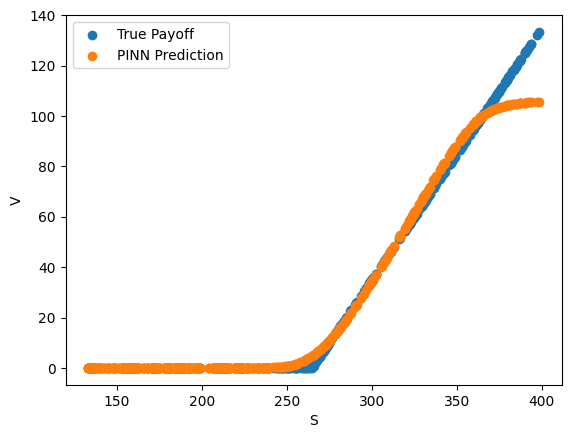

In [ ]:
V_ic_val_pred = model(tf.convert_to_tensor(inputs_ic_val))
plt.scatter(S_ic_val, V_ic_val, label='True Payoff')
plt.scatter(S_ic_val, V_ic_val_pred.numpy(), label='PINN Prediction')
plt.xlabel('S')
plt.ylabel('V')
plt.legend()
plt.show()